In [1]:
import zipfile
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import string
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Lambda, concatenate, add
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
flickr8k.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
with zipfile.ZipFile("/content/flickr8k.zip", 'r') as zip_ref:
    zip_ref.extractall("flickr8k")

In [4]:
def extract_features(image_paths, model):
    features = {}
    # Add progress bar
    from tqdm import tqdm

    for image_path in tqdm(image_paths):
        try:
            # Extract image ID from path (keep only filename)
            image_id = os.path.basename(image_path)

            # Load and preprocess image
            img = load_img(image_path, target_size=(299, 299))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Extract features using the model
            feature = model.predict(img_array, verbose=0)

            # Reshape and store features
            features[image_id] = feature.reshape(2048,)

        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            continue

    return features

In [5]:
# Directory containing Flickr8k images
image_dir = '/content/flickr8k/Images'
# Get list of image paths
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
               if fname.endswith(('.jpg', '.jpeg', '.png'))]

# Load InceptionV3 model pre-trained on ImageNet
base_model = InceptionV3(weights='imagenet')
feature_extractor = Model(inputs=base_model.input,
                         outputs=base_model.get_layer('avg_pool').output)
image_features = extract_features(image_paths, feature_extractor)
print(feature_extractor.summary())

100%|██████████| 8091/8091 [12:18<00:00, 10.95it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [6]:
def load_captions(captions_file):
    captions = {}

    with open(captions_file, 'r') as f:
        next(f)  # Skip the header line (image,caption)
        for line in f:
            line = line.strip()
            if line:  # Skip empty lines
                try:
                    # Split by first comma
                    img_id, caption = line.split(',', 1)
                    # Add caption to list for this image ID
                    captions.setdefault(img_id, []).append(caption)
                except ValueError:
                    print(f"Warning: Skipping invalid line: {line}")

    return captions


def clean_captions(captions):
    cleaned_captions = {}

    for img_id, caps in captions.items():
        cleaned_caps = []
        for cap in caps:
            # Convert to lowercase
            cap = cap.lower()
            # Remove special characters but keep periods and spaces
            cap = ' '.join(cap.split())
            # Remove multiple spaces
            cap = ' '.join(word for word in cap.split() if word)
            # Add tokens only if not already present
            if not cap.startswith('<start>'):
                cap = '<start> ' + cap
            if not cap.endswith('<end>'):
                cap = cap + ' <end>'
            cleaned_caps.append(cap)
        cleaned_captions[img_id] = cleaned_caps
    return cleaned_captions

def build_vocabulary(cleaned_captions, threshold=5):
    word_counts = Counter()
    max_length = 0

    # Count words and find max sequence length
    for caps in cleaned_captions.values():
        for cap in caps:
            words = cap.split()
            max_length = max(max_length, len(words))
            word_counts.update(words)

    # Filter vocabulary
    # Ensure '<unk>' is in the vocabulary regardless of count
    vocabulary = ['<pad>', '<start>', '<end>', '<unk>'] + [  # Added '<start>', '<end>', '<unk>'
        word for word, count in word_counts.items() if count >= threshold
    ]


    # Create mappings
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word, max_length

In [7]:
captions = load_captions('/content/flickr8k/captions.txt') # Load captions from file
print(f"Number of Captions: {len(captions)}")
cleaned_captions = clean_captions(captions) # Now pass the dictionary to clean_captions

# Build vocabulary
vocabulary, word_to_idx, idx_to_word, max_length = build_vocabulary(cleaned_captions)
vocab_size = len(vocabulary)

Number of Captions: 8091


In [8]:
print(f"Number of images with captions: {len(captions)}")
# Print a few examples to verify
for image_id, caption_list in list(captions.items())[:5]:
    print(f"Image ID: {image_id} | Captions: {caption_list}")

Number of images with captions: 8091
Image ID: 1000268201_693b08cb0e.jpg | Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image ID: 1001773457_577c3a7d70.jpg | Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
Image ID: 1002674143_1b742ab4b8.jpg | Captions: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with 

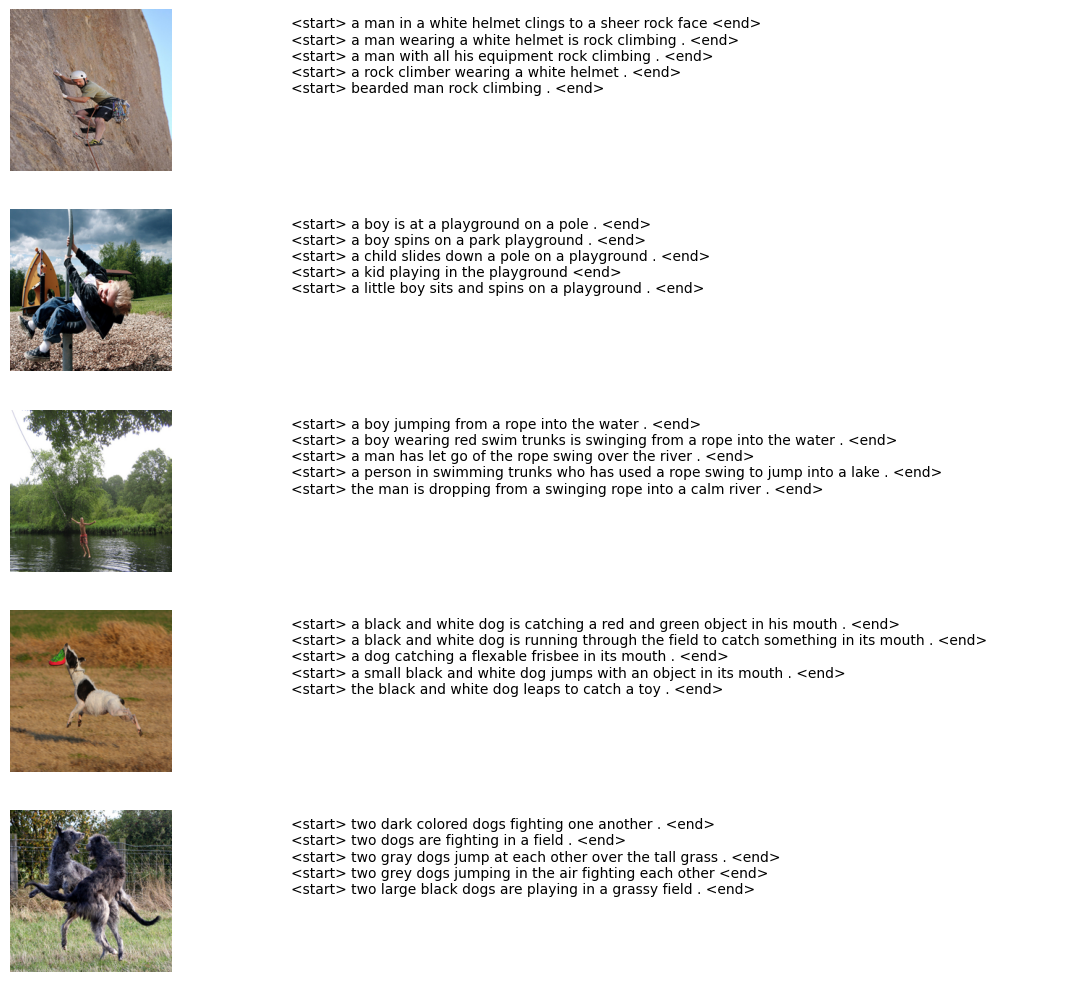

In [9]:
def display_random_images_captions(cleaned_captions, images_dir, num_samples=5):
    # Select random image-caption pairs
    random_pairs = random.sample(list(cleaned_captions.items()), num_samples)

    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 10))

    for idx, (image_id, captions) in enumerate(random_pairs, 1):
        # Load and display image
        image_path = os.path.join(images_dir, image_id)
        image = Image.open(image_path)
        image = image.resize((224, 224))  # Resize for display
        # Create subplot
        plt.subplot(num_samples, 2, (idx * 2) - 1)
        plt.imshow(image)
        plt.axis('off')

        # Display captions
        plt.subplot(num_samples, 2, idx * 2)
        plt.text(0, 0.5, '\n'.join(captions), wrap=True)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Usage
images_dir = '/content/flickr8k/Images'
display_random_images_captions(cleaned_captions, images_dir)


In [10]:
def create_train_test_split(captions_dict, features_dict, split_ratio=0.8, random_state=42):

    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Get all image IDs
    image_ids = list(captions_dict.keys())
    np.random.shuffle(image_ids)

    # Calculate split point
    split_idx = int(len(image_ids) * split_ratio)

    # Create splits
    train_ids = image_ids[:split_idx]
    test_ids = image_ids[split_idx:]

    # Create dictionaries for train and test sets
    train_captions = {img_id: captions_dict[img_id] for img_id in train_ids}
    test_captions = {img_id: captions_dict[img_id] for img_id in test_ids}

    train_features = {img_id: features_dict[img_id] for img_id in train_ids}
    test_features = {img_id: features_dict[img_id] for img_id in test_ids}

    # Create validation generators
    train_generator = data_generator(
        train_captions,
        train_features,
        word_to_idx,
        max_length,
        batch_size=32
    )

    val_generator = data_generator(
        test_captions,
        test_features,
        word_to_idx,
        max_length,
        batch_size=32
    )

    # Calculate steps per epoch
    train_steps = len(train_ids) // 32
    val_steps = len(test_ids) // 32
    if not captions_dict or not features_dict:
        raise ValueError("Empty dictionaries provided")

    if not set(captions_dict.keys()) == set(features_dict.keys()):
        raise ValueError("Mismatch between captions and features keys")

    if split_ratio <= 0 or split_ratio >= 1:
        raise ValueError("Split ratio must be between 0 and 1")
    return {
        'train_generator': train_generator,
        'val_generator': val_generator,
        'train_steps': train_steps,
        'val_steps': val_steps,
        'train_ids': train_ids,
        'test_ids': test_ids
    }

In [11]:
def build_caption_generator(vocab_size, max_length, embedding_dim=256, rnn_units=512):
    # Image input
    image_input = Input(shape=(2048,), name='image_input')
    # Caption input
    caption_input = Input(shape=(max_length,), name='caption_input')

    # Process image features
    image_features = Dense(embedding_dim, activation='relu')(image_input)
    image_features = Dropout(0.5)(image_features)

    # Expand dimensions and repeat to match caption sequence length
    image_features_expanded = Lambda(lambda x: tf.expand_dims(x, 1))(image_features)
    image_features_repeated = Lambda(lambda x: tf.repeat(x, max_length, axis=1))(image_features_expanded)

    # Embedding for captions
    caption_embedding = Embedding(vocab_size, embedding_dim)(caption_input)

    # Concatenate image features and caption embeddings
    merged_input = concatenate([image_features_repeated, caption_embedding], axis=2)

    # RNN decoder
    lstm_output = LSTM(rnn_units, return_sequences=True)(merged_input)

    # Dense layer for word prediction
    outputs = Dense(vocab_size, activation='softmax')(lstm_output)

    # Model definition
    model = Model(inputs={'image_input': image_input, 'caption_input': caption_input},
                  outputs=outputs)

    # Compile the model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [12]:
def data_generator(captions_dict, features_dict, word_to_idx, max_length, batch_size):
    image_ids = list(captions_dict.keys())
    while True:
        np.random.shuffle(image_ids)
        for i in range(0, len(image_ids), batch_size):
            batch_ids = image_ids[i:i + batch_size]
            batch_X1, batch_X2, batch_y = [], [], []

            for img_id in batch_ids:
                caption = np.random.choice(captions_dict[img_id])
                seq = ['<start>'] + caption.split() + ['<end>']
                seq = [word_to_idx.get(word, word_to_idx['<unk>']) for word in seq]

                # Pad sequence to fixed length
                padded_seq = tf.keras.preprocessing.sequence.pad_sequences(
                    [seq], maxlen=max_length+1, padding='post')[0]

                # Input sequence and target sequence
                input_seq = padded_seq[:-1]
                target_seq = padded_seq[1:]

                # Ensure correct feature shape
                batch_X1.append(features_dict[img_id].reshape(2048))
                batch_X2.append(input_seq)
                batch_y.append(target_seq)

            # Convert to numpy arrays with correct shapes
            batch_X1 = np.array(batch_X1)
            batch_X2 = np.array(batch_X2)
            batch_y = np.array(batch_y)

            yield {
                'image_input': batch_X1,
                'caption_input': batch_X2
            }, batch_y

In [13]:
def generate_caption(model, image_features, word_to_idx, idx_to_word, max_length, temperature=0.4, beam_size=3):
    input_text = ['<start>']
    candidates = [(input_text, 0.0)]

    for _ in range(max_length):
        new_candidates = []

        for sequence, score in candidates:
            if sequence[-1] == '<end>':
                new_candidates.append((sequence, score))
                continue

            sequence_ids = [word_to_idx[word] for word in sequence]
            sequence_ids = pad_sequences([sequence_ids], maxlen=max_length)

            predictions = model.predict({
                'image_input': image_features.reshape(1, 2048),
                'caption_input': sequence_ids
            }, verbose=0)

            # Length normalization for better long caption generation
            length_penalty = ((5 + len(sequence)) ** 0.75) / (6 ** 0.75)

            # Dynamic temperature scaling
            temp = temperature * (1 - len(sequence)/max_length)
            word_probs = predictions[0][-1] / temp
            word_probs = np.exp(word_probs) / np.sum(np.exp(word_probs))

            # Sample from top-k with nucleus sampling
            top_k = min(beam_size * 3, len(word_probs))
            top_indices = np.argsort(word_probs)[-top_k:]
            cumulative_probs = np.cumsum(word_probs[top_indices])
            cutoff_index = np.searchsorted(cumulative_probs, 0.9)
            top_indices = top_indices[:cutoff_index+1]

            for idx in top_indices:
                if idx_to_word.get(idx) not in ['<pad>', '<unk>']:
                    new_sequence = sequence + [idx_to_word[idx]]
                    new_score = (score + np.log(word_probs[idx])) / length_penalty
                    new_candidates.append((new_sequence, new_score))

        candidates = sorted(new_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

        if all(c[0][-1] == '<end>' for c in candidates):
            break

    best_sequence = candidates[0][0]
    caption = [word for word in best_sequence if word not in ['<start>', '<end>', '<pad>', '<unk>']]
    return ' '.join(caption)

In [14]:
# 1. Create train-test split
split_data = create_train_test_split(
    cleaned_captions,
    image_features,
    split_ratio=0.8
)

# 2. Build the model
model = build_caption_generator(
    vocab_size=vocab_size,
    max_length=max_length,
    embedding_dim=256,
    rnn_units=512
)

tf.config.run_functions_eagerly(True)

# 3. Train the model
history = model.fit(
    split_data['train_generator'],
    steps_per_epoch=split_data['train_steps'],
    epochs=50,
    validation_data=split_data['val_generator'],
    validation_steps=split_data['val_steps'],
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2)
    ]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


202/202 ━━━━━━━━━━━━━━━━━━━━ 29s 122ms/step - accuracy: 0.6497 - loss: 2.4907 - val_accuracy: 0.7726 - val_loss: 1.3592 - learning_rate: 0.0010
Epoch 2/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.7769 - loss: 1.2897 - val_accuracy: 0.7850 - val_loss: 1.1952 - learning_rate: 0.0010
Epoch 3/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 23s 116ms/step - accuracy: 0.7875 - loss: 1.1602 - val_accuracy: 0.7925 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 4/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.7958 - loss: 1.0800 - val_accuracy: 0.7973 - val_loss: 1.0626 - learning_rate: 0.0010
Epoch 5/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.7948 - loss: 1.0532 - val_accuracy: 0.7996 - val_loss: 1.0213 - learning_rate: 0.0010
Epoch 6/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.8003 - loss: 1.0032 - val_accuracy: 0.8029 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 7/50
202/202 ━━━━━━━━━━━━━━━━━━━━ 24s 119ms/step - accuracy: 0.8016 - loss:

In [16]:
def predict_caption(image_path, captions_dict):
    # Load and display image
    img = load_img(image_path, target_size=(299, 299))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')

    # Get actual captions
    img_id = os.path.basename(image_path)
    actual_captions = captions_dict.get(img_id, ['No captions available'])

    # Preprocess image for prediction
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Extract features and generate caption
    features = feature_extractor.predict(img_array, verbose=0)
    generated_caption = generate_caption(model, features[0], word_to_idx, idx_to_word, max_length)

    # Calculate BLEU scores
    bleu1, bleu2 = calculate_bleu_scores(actual_captions, generated_caption)

    # Display results
    print("\nActual Captions:")
    for i, caption in enumerate(actual_captions, 1):
        print(f"{i}. {caption}")

    print("\nGenerated Caption:")
    print(generated_caption)

    print("\nBLEU Scores:")
    print(f"BLEU-1: {bleu1:.4f}")
    print(f"BLEU-2: {bleu2:.4f}")

    plt.show()

def calculate_bleu_scores(actual_captions, predicted_caption):
    # Remove special tokens from predicted caption
    predicted = predicted_caption.replace('<start>', '').replace('<end>', '').strip().split()

    # Process reference captions
    references = []
    for caption in actual_captions:
        # Clean reference captions
        clean_caption = caption.replace('<start>', '').replace('<end>', '').strip().split()
        references.append(clean_caption)

    # Calculate BLEU scores for different n-grams
    bleu1 = sentence_bleu(references, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = sentence_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))

    return bleu1, bleu2


Actual Captions:
1. <start> a brown dog playing play wrestling with a black dog on snow covered land . <end>
2. <start> the two dogs are fighting outside in the snow . <end>
3. <start> two brown dogs playing in snow <end>
4. <start> two dogs are wrestling in a snow covered field . <end>
5. <start> two dogs playing on snow covered ground <end>

Generated Caption:
two dogs are running in the snow .

BLEU Scores:
BLEU-1: 0.8750
BLEU-2: 0.7906


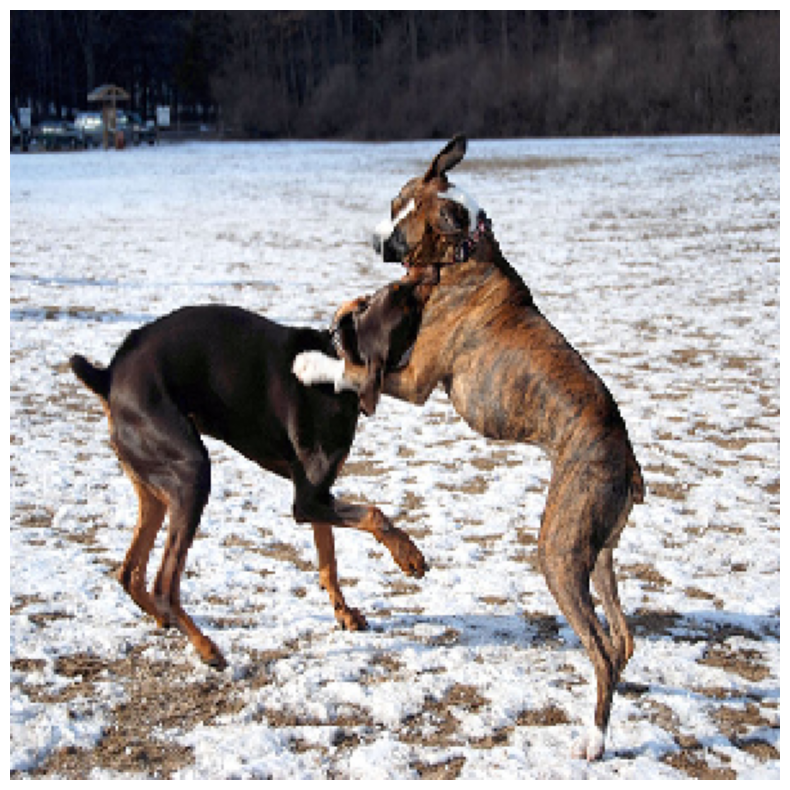

In [17]:
# Test the model
test_image = random.choice(split_data['test_ids'])
test_image_path = f'flickr8k/Images/{test_image}'
predict_caption(test_image_path, cleaned_captions)